In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np # library which more efficiently allows you to work with large multidimensional arrays and matrices.  It has functions that operate on the arrays/matrices
import pandas as pd # built on numpy.  Makes it easier to read in data and clean data among other things

import sklearn

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder # Scaling is suggested when running a gradient descent algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy.random as r

# drive.mount('/content/drive')

%matplotlib inline

Preprocessing the data!

In [2]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Modulation_Original'] = rf_data['Modulation']
rf_data['Modulation'] = label_encoder.fit_transform(rf_data['Modulation']) + 1  # Add 1 to avoid 0 indexing
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original','Weather Condition','Antenna Type' ])]

y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X)

#print(X_train)

                  Timestamp  Frequency  Signal Strength  Modulation  \
0       2023-05-05 00:00:00  120000000              -44           5   
1       2023-05-05 00:00:20  160000000              -97           4   
2       2023-05-05 00:00:40   90000000              -87           3   
3       2023-05-05 00:01:00  160000000              -29           4   
4       2023-05-05 00:01:20   70000000              -26           1   
...                     ...        ...              ...         ...   
164155  2023-06-11 23:58:20  160000000              -63           3   
164156  2023-06-11 23:58:40  120000000              -15           5   
164157  2023-06-11 23:59:00  160000000              -97           4   
164158  2023-06-11 23:59:20  120000000              -29           2   
164159  2023-06-11 23:59:40   70000000              -68           5   

        Bandwidth      Location Device Type  Antenna Type  Temperature  \
0           50000  Patna, Bihar      HackRF             4           24   

# Supervised Analysis I: Logistic Regression

Process the data so that we can perform logistic regression:

In [3]:
ones = np.ones((X_train.shape[0],1))
ones2 = np.ones((X_test.shape[0],1))
X_train_logistic = np.hstack((ones,X_train))
X_test_logistic = np.hstack((ones2,X_test))

y_2d_train = np.array(y_train).reshape(-1, 1)
y_2d_test = np.array(y_test).reshape(-1, 1)

enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(y_2d_train)
y_2d_train_log = enc.transform(y_2d_train).toarray()
print(y_2d_train_log.shape)

enc.fit(y_2d_test)
y_2d_test_log = enc.transform(y_2d_test).toarray()
print(y_2d_test_log.shape)

(123120, 6)
(41040, 6)


Define the necessary functions:

In [4]:
#sigmoid function
def sigmoid(z):
  return 1/(1+np.exp(-z))
# print(sigmoid(0))

w_init = np.random.randn(X_train_logistic.shape[1],1)

#print(w_init)

#hypothesis function
def hypothesis(X, w):
    return sigmoid(X.dot(w)) #check over if models not working

# y_hat_init = hypothesis(X_train_logistic,w_init)

def log_likelihood(X, y, w):
    z = hypothesis(X,w)
    result = ((y*(np.log(z))) + (1-y)*np.log(1-z)).sum()

    return result # you should return a real number, not a list containing a real number

# Write the gradient ascent function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-hypothesis(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(log_likelihood(X, y, w))
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values



Let's try different learning rates and iteration values:

In [5]:
# Please try many different values for the learning rate (including very small values).
learning_rate = 0.01
num_iters = 500
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train, learning_rate, num_iters)
# print(log_likelihood_values)

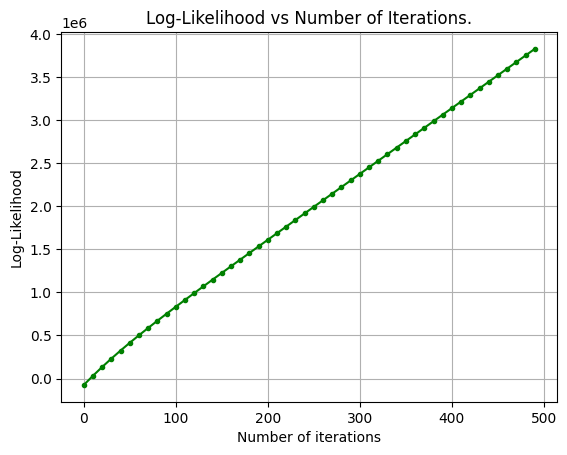

In [6]:
iters = np.array(range(0,num_iters,10))
# iters = np.array(range(num_iters))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)


Let's predict Modulation Classes using Soft-max logistic regression

(41040, 6) (41040, 6) (123120, 6)


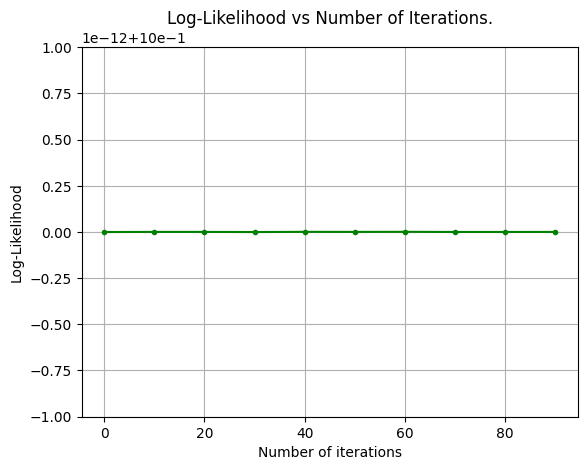

[[4.06483763e-06 4.07215720e-06 4.08205626e-06 4.06467590e-06
  4.04437017e-06 4.03833676e-06]
 [4.04442768e-06 4.05326212e-06 4.05873604e-06 4.04740117e-06
  4.07430449e-06 4.08830953e-06]
 [4.10506417e-06 4.08779078e-06 4.03879395e-06 4.06239009e-06
  4.05758734e-06 4.01528400e-06]
 ...
 [4.07586254e-06 4.05823689e-06 4.02102604e-06 4.05281008e-06
  4.09480287e-06 4.06390003e-06]
 [4.06551575e-06 4.07317775e-06 4.05889073e-06 4.07196400e-06
  4.04670667e-06 4.05008418e-06]
 [4.09486703e-06 4.07564063e-06 4.03439138e-06 4.05268773e-06
  4.06676356e-06 4.04222327e-06]]


In [7]:
#check one hot encoding
# print(y_2d_train_log)

#reshape w_init for softmax
# w_init = np.random.randn(X_train_logistic.shape[1],y_2d_test_log.shape[1])
w_init = np.zeros((X_train_logistic.shape[1],y_2d_test_log.shape[1]))


# print(w_init)
# print(w_init.shape)

#define softmax function
def softmax(X,w):
    e_x = np.exp(X.dot(w))
    return e_x / e_x.sum()

#define log_likelihood
def log_likelihood(X, y, w):
    p_scores = softmax(X,w)
    result = (y.T.dot(np.log(p_scores))).sum()

    return result

#define new Gradient Ascent Function
def Gradient_Ascent(X, y, learning_rate, num_iters):
    # We assume X has been augmented with a column of ones

    # Number of training examples.
    N = X.shape[0]

    # Initialize w(<np.ndarray>). Zeros vector of shape X.shape[1],1
    w = np.zeros((X.shape[1],y.shape[1]))

    # Initiating list to store values of likelihood(<list>) after few iterations.
    log_likelihood_values = []

    # Gradient Ascent - local optimization technique
    for i in range(num_iters):
        w += (learning_rate/N)*((X.T).dot(y-softmax(X,w)))
        # Computing log likelihood of seeing examples for current value of w
        if (i % 10) == 0:
            log_likelihood_values.append(softmax(X,w).sum())
            #print(log_likelihood(X, y, w))

    return w, log_likelihood_values

# print(log_likelihood(X_train_logistic,y_2d_train_log,w_init))

# Please try many different values for the learning rate (including very small values).
learning_rate = .01
num_iters = 100
# Calculate w and likelihood values using Gradient_Ascent with X_train_1, y_2d_train
w, log_likelihood_values = Gradient_Ascent(X_train_logistic, y_2d_train_log, learning_rate, num_iters)
# print(w, log_likelihood_values)
y_result_test = softmax(X_test_logistic,w)

# correct = 0
# for i in range(y_result_test.shape[0]):
#   if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test[i, :]):
#     correct += 1
# accuracy = correct / y_result_test.shape[0]
# print(accuracy)


# print(y_2d_test.shape, y_result_test.shape)
# for i in range(y_result_test.shape[0]):
#   y_result_test[i, :] = np.argmax(y_result_test[i, :])
#   y_2d_test[i, :] = np.argmax(y_2d_test[i, :])
# print(y_2d_test.shape, y_result_test.shape)



print(y_2d_test_log.shape, y_result_test.shape, y_2d_train_log.shape)


correct = 0
for i in range(y_result_test.shape[0]):
  if np.argmax(y_result_test[i, :]) == np.argmax(y_2d_test_log[i, :]):
    correct += 1
accuracy = correct / y_result_test.shape[0]
# print(accuracy)

# accuracy = accuracy_score(y_2d_test_log, y_result_test)

iters = np.array(range(0,num_iters,10))
plt.plot(iters,log_likelihood_values,'.-',color='green')
plt.xlabel('Number of iterations')
plt.ylabel('Log-Likelihood')
plt.title("Log-Likelihood vs Number of Iterations.")
plt.grid()
plt.show(block=False)

print(y_result_test)

# Supervised Analysis II: Support Vector Machine


Let's load the data again to make it easier to work with for SVM's


In [8]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original'])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train)

                  Timestamp  Frequency  Signal Strength Modulation  Bandwidth  \
0       2023-05-05 00:00:00  120000000              -44        QAM      50000   
1       2023-05-05 00:00:20  160000000              -97         FM    1000000   
2       2023-05-05 00:00:40   90000000              -87       BPSK     500000   
3       2023-05-05 00:01:00  160000000              -29         FM     100000   
4       2023-05-05 00:01:20   70000000              -26       8PSK      10000   
...                     ...        ...              ...        ...        ...   
164155  2023-06-11 23:58:20  160000000              -63       BPSK     200000   
164156  2023-06-11 23:58:40  120000000              -15        QAM      10000   
164157  2023-06-11 23:59:00  160000000              -97         FM      10000   
164158  2023-06-11 23:59:20  120000000              -29         AM     500000   
164159  2023-06-11 23:59:40   70000000              -68        QAM     100000   

            Location Device

Define all the functions necessary for SVM's

In [9]:
print(X_train)

print(y_train)

def one_vs_rest_encoding(y, modul = '8PSK'):
    y_encoded = np.where(y==modul,1,-1)
    return  y_encoded

def score(X, w):
    # To do
    return X.dot(w)

def svm_objective(w, X, y, lambda1=.1):
    # To do. This part may require several lines of code.
    # Store your answer in result.
    w0 = 0
    max_sum = np.sum(np.maximum(0,1 - y*(X.dot(w) + w0)))
    print(max_sum)
    result = (lambda1/2)*np.sum(w**2) + max_sum
    return result

#Pegasos' Algorithm
def pegasos(X_train, y_train, lambda1=0.08, num_iters=100):
    # Hyperparameters: threshold, lambda1

    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):

        #print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range(N):
            t = t + 1
            alpha = 1 / (lambda1 * t)
            # Complete the following code to find w. This will require several lines of code.
            if ((y_train[i] * w.T.dot(X_train[i])) >= 1):
                w = w - (alpha * lambda1 * w)
            else:
                w = w - alpha * (lambda1 * w - y_train[i] * X_train[i])

    return w

y_train_0_vs_rest = one_vs_rest_encoding(y_train, '8PSK')
print(y_train_0_vs_rest)
y_test_0_vs_rest = one_vs_rest_encoding(y_test, '8PSK')
print(y_test_0_vs_rest)







[[-4.41166997e-01  1.57371645e+00  5.48172197e-01 ...  1.72882116e-01
  -2.84217094e-14 -1.22424934e+00]
 [ 8.76698385e-01  1.64219319e+00  1.98792039e+00 ...  4.10094568e-01
  -2.84217094e-14  1.22763482e+00]
 [-7.70633342e-01 -2.06678848e-01 -7.47601178e-01 ... -9.35238910e-01
  -2.84217094e-14  1.22763482e+00]
 ...
 [-4.41166997e-01  1.40252459e+00 -7.47601178e-01 ... -1.24700385e+00
  -2.84217094e-14 -1.22424934e+00]
 [ 2.17765694e-01 -8.22969528e-01 -3.15676719e-01 ...  1.72882116e-01
  -2.84217094e-14  1.22763482e+00]
 [-1.42956603e+00  1.33404785e+00 -8.62781033e-01 ... -3.76095273e-01
  -2.84217094e-14  1.22763482e+00]]
152142    QPSK
75633     BPSK
135918    8PSK
124764     QAM
153192    BPSK
          ... 
119879    8PSK
103694      FM
131932    BPSK
146867    8PSK
121958    QPSK
Name: Modulation, Length: 123120, dtype: object
[-1 -1  1 ... -1  1 -1]
[-1  1 -1 ...  1 -1 -1]


Training the SVM

In [10]:


lambda1 = 0.01  # Regularization parameter
num_iters = 10   # Number of iterations

# A) Create the 10 classifiers
labels = ['8PSK','AM','BPSK','FM','QAM','QPSK']
w_vals= {}
val_scores = {}



for i in range(len(labels)):
    # Perform one-vs-rest for labels[i]
    # To do: Relabel the y labels in the train set to either 1 or -1 using one_vs_rest_encoding
    y_encoded = one_vs_rest_encoding(y_train,labels[i])
    #print(y_encoded)
    # To do: Train the Pegasos algorithm on X_train X_train and  y_encoded to get the weight vector
    w_vals[i] = pegasos(X_train, y_encoded,lambda1,num_iters)


    # Using the validation set, estimate accuracy for one-vs-rest classifier for labels[i]
    # To do:  Relabel the y labels in the validation set to either 1 or -1 using one_vs_rest_encoding
    y_encoded_val = one_vs_rest_encoding(y_test,labels[i])

    # This section may require more than one line of code.
    # To do: Calculate an accuracy for one-vs-rest classifier for labels[i]
    predict = np.sign(X_test.dot(w_vals[i]))
    correct_predicts = (predict == y_encoded_val)
    num_correct = np.sum(correct_predicts)

    total_samples = y_test.shape[0]
    accuracy = num_correct / total_samples

    val_scores[i] = accuracy

In [11]:
print(y_train)

for i in range(1, len(labels) + 1):
    print(labels[i-1], ": score:", val_scores[i - 1])

152142    QPSK
75633     BPSK
135918    8PSK
124764     QAM
153192    BPSK
          ... 
119879    8PSK
103694      FM
131932    BPSK
146867    8PSK
121958    QPSK
Name: Modulation, Length: 123120, dtype: object
8PSK : score: 0.4979288499025341
AM : score: 0.49987816764132553
BPSK : score: 0.5078947368421053
FM : score: 0.5011939571150097
QAM : score: 0.5013888888888889
QPSK : score: 0.5020955165692008


Let's make an array of predictions

In [12]:
# Making predictions
predictions = []
for sample in X_test:
    modul_scores = []
    for i in range(len(labels)):
        modul_score = score(sample, w_vals[i])
        modul_scores.append(modul_score)
    predicted_modulation = np.argmax(modul_scores)
    predictions.append(labels[predicted_modulation])

print("Predictions:", predictions)

Predictions: ['BPSK', 'QAM', '8PSK', 'FM', 'BPSK', 'AM', 'FM', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', 'AM', 'AM', 'QPSK', 'FM', 'QAM', 'AM', 'BPSK', 'AM', 'BPSK', 'FM', 'QPSK', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', '8PSK', 'BPSK', 'FM', 'AM', 'QPSK', 'AM', 'FM', 'QAM', 'FM', 'QPSK', 'FM', 'BPSK', 'BPSK', 'FM', 'BPSK', 'FM', 'QAM', 'QPSK', 'QAM', '8PSK', 'AM', 'BPSK', 'QAM', 'BPSK', 'AM', 'QPSK', '8PSK', 'FM', 'BPSK', 'BPSK', 'FM', '8PSK', 'FM', '8PSK', '8PSK', 'FM', 'BPSK', 'QPSK', '8PSK', 'FM', '8PSK', 'AM', 'QPSK', 'QAM', 'QPSK', '8PSK', '8PSK', '8PSK', 'AM', 'AM', 'QPSK', 'AM', 'QAM', 'QPSK', '8PSK', 'QAM', 'FM', 'FM', 'AM', 'AM', 'BPSK', 'AM', 'QPSK', '8PSK', 'QPSK', 'QPSK', 'AM', 'FM', 'QAM', 'AM', 'AM', 'QAM', 'QPSK', 'QAM', 'BPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'QAM', '8PSK', '8PSK', 'BPSK', 'BPSK', 'QAM', 'QAM', '8PSK', 'QPSK', 'FM', 'FM', 'QAM', 'QPSK', 'QPSK', 'QPSK', 'QPSK', 'BPSK', 'QPSK', 'QPSK', 'QPSK', 'QAM', 'BPSK', '8PSK', 'QPSK', 'AM', 'FM', '8PSK', 'QPSK', 'QPSK', 'QPSK', 'A

Let's check accuracy

In [13]:
y_test_list = y_test.to_list()
eval1 = np.zeros(y_test.shape[0])
print(predictions)
print(y_test_list)

# Loop through each prediction and compare with the actual label
for i in range(len(predictions)):
    #print(predictions[i],y_val[i])
    if predictions[i] == y_test_list[i]:
        eval1[i] = 1  # Correct prediction
    else:
        eval1[i] = 0  # Incorrect prediction

# Calculate the accuracy on the validation set
accuracy = np.mean(eval1)
print("Accuracy Score:", accuracy)


['BPSK', 'QAM', '8PSK', 'FM', 'BPSK', 'AM', 'FM', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', 'AM', 'AM', 'QPSK', 'FM', 'QAM', 'AM', 'BPSK', 'AM', 'BPSK', 'FM', 'QPSK', 'QPSK', 'BPSK', 'FM', 'FM', 'QAM', '8PSK', 'BPSK', 'FM', 'AM', 'QPSK', 'AM', 'FM', 'QAM', 'FM', 'QPSK', 'FM', 'BPSK', 'BPSK', 'FM', 'BPSK', 'FM', 'QAM', 'QPSK', 'QAM', '8PSK', 'AM', 'BPSK', 'QAM', 'BPSK', 'AM', 'QPSK', '8PSK', 'FM', 'BPSK', 'BPSK', 'FM', '8PSK', 'FM', '8PSK', '8PSK', 'FM', 'BPSK', 'QPSK', '8PSK', 'FM', '8PSK', 'AM', 'QPSK', 'QAM', 'QPSK', '8PSK', '8PSK', '8PSK', 'AM', 'AM', 'QPSK', 'AM', 'QAM', 'QPSK', '8PSK', 'QAM', 'FM', 'FM', 'AM', 'AM', 'BPSK', 'AM', 'QPSK', '8PSK', 'QPSK', 'QPSK', 'AM', 'FM', 'QAM', 'AM', 'AM', 'QAM', 'QPSK', 'QAM', 'BPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'QAM', '8PSK', '8PSK', 'BPSK', 'BPSK', 'QAM', 'QAM', '8PSK', 'QPSK', 'FM', 'FM', 'QAM', 'QPSK', 'QPSK', 'QPSK', 'QPSK', 'BPSK', 'QPSK', 'QPSK', 'QPSK', 'QAM', 'BPSK', '8PSK', 'QPSK', 'AM', 'FM', '8PSK', 'QPSK', 'QPSK', 'QPSK', 'AM', 'QAM', 'A

# Supervised Analysis III: Neural Network

Reload the data

In [14]:
file_path = "rf_signal_data.csv"
rf_data = pd.read_csv(file_path)

#check how the data looks
#print(rf_data)

#Let's hot encode the modulation types, weather conditions, interference type, Antenna Type, and device status using integers
label_encoder = LabelEncoder()
rf_data['Interference Type'] = label_encoder.fit_transform(rf_data['Interference Type']) + 1
rf_data['Weather Condition'] = label_encoder.fit_transform(rf_data['Weather Condition']) + 1
rf_data['Device Status'] = label_encoder.fit_transform(rf_data['Device Status']) + 1
rf_data['Antenna Type'] = label_encoder.fit_transform(rf_data['Antenna Type']) + 1
print(rf_data)

X = rf_data.loc[:,~rf_data.columns.isin(['Modulation','Timestamp','Location','Device Type','Latitude','Longitude','Altitude','Air Pressure','I/Q Data','Modulation_Original'])]
y = rf_data['Modulation']

#Split the data into test data and validation data
X_train, X_test, y_train, y_test = train_test_split( X, y,random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print(X_train)

                  Timestamp  Frequency  Signal Strength Modulation  Bandwidth  \
0       2023-05-05 00:00:00  120000000              -44        QAM      50000   
1       2023-05-05 00:00:20  160000000              -97         FM    1000000   
2       2023-05-05 00:00:40   90000000              -87       BPSK     500000   
3       2023-05-05 00:01:00  160000000              -29         FM     100000   
4       2023-05-05 00:01:20   70000000              -26       8PSK      10000   
...                     ...        ...              ...        ...        ...   
164155  2023-06-11 23:58:20  160000000              -63       BPSK     200000   
164156  2023-06-11 23:58:40  120000000              -15        QAM      10000   
164157  2023-06-11 23:59:00  160000000              -97         FM      10000   
164158  2023-06-11 23:59:20  120000000              -29         AM     500000   
164159  2023-06-11 23:59:40   70000000              -68        QAM     100000   

            Location Device

In [15]:
# Assuming X_train, y_train, X_test, and y_test are your data

# Create and train the neural network model
model = MLPClassifier(hidden_layer_sizes=(6), activation='tanh', solver='adam', random_state=1, max_iter=50)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(y_pred ,y_test)
print(coefficient_of_dermination)


activation_functions = ['sigmoid','relu','tanh','elu']

Accuracy: 0.1699805068226121


ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [16]:
from sklearn.model_selection import cross_val_score

# Create and train the neural network model with multiple hidden layers
model = MLPClassifier(hidden_layer_sizes=(6,), activation='tanh', solver='adam', random_state=1, max_iter=300)

# Perform cross-validation to get training and validation errors
train_errors = []
val_errors = []
for _ in range(5):  # Repeat cross-validation 5 times
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    train_errors.append(1 - scores.mean())  # Training error
    val_errors.append(1 - scores)  # Validation error

# Plot training and validation errors
plt.plot(np.mean(train_errors, axis=0), label='Training Error')
plt.plot(np.mean(val_errors, axis=0), label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
print(train_errors)
print(val_errors)

[0.8345679012345679, 0.8345679012345679, 0.8345679012345679, 0.8345679012345679, 0.8345679012345679]
[array([0.83532326, 0.83410494, 0.83402372, 0.83520143, 0.83418616]), array([0.83532326, 0.83410494, 0.83402372, 0.83520143, 0.83418616]), array([0.83532326, 0.83410494, 0.83402372, 0.83520143, 0.83418616]), array([0.83532326, 0.83410494, 0.83402372, 0.83520143, 0.83418616]), array([0.83532326, 0.83410494, 0.83402372, 0.83520143, 0.83418616])]
